In [88]:
# #### run once before each notebook execution and clear output
# %pip install pandas_datareader 
# %pip install statsmodels
# %pip install linearmodels
# %pip install quantstats
# %pip install wrds
# %pip install pathlib
# %pip install scipy
# %pip install sklearn
# %pip install pandas_datareader 
# %pip install tqdm
# %pip install ZipFile
# %pip install seaborn
# %pip install matplotlib
# %pip install xgboost
# %pip install quandl
# %pip install keras
# %pip install --upgrade tensorflow 
# %pip install shap

# print('############################# completed installations #####################')

In [89]:
# after we install all the packages, import all of them for the use in today's lecture!
# database access
import boto3
from sagemaker import get_execution_role
import s3fs
import h5py
import tempfile

import quandl as quandl
import wrds as wrds
# storage and operations
import pandas as pd
import numpy as np
import datetime
from pathlib import Path
import seaborn as sns

# stats
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from scipy import stats
from scipy.stats.mstats import winsorize
import os
from tqdm import tqdm
from zipfile import ZipFile
import seaborn
import matplotlib.pyplot as plt
import linearmodels as lm
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

#portfolio optimization:
# libraries we might use for testing
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import linearmodels as lm
from linearmodels.panel import compare  
import time
import quantstats as qs
import tensorflow as tf
from tensorflow import keras
import xgboost

from sklearn.metrics import mean_squared_error, r2_score

from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import gc

# path_factors = Path(r'C:\Users\mauri\FSoF\Frankfurt School of Finance - Master Thesis\Master Thesis - Data\Factors')
# path_wrds = Path(r'C:\Users\mauri\FSoF\Frankfurt School of Finance - Master Thesis\Master Thesis - Data\WRDS')
# path_ml = Path(r'C:\Users\mauri\FSoF\Frankfurt School of Finance - Master Thesis\Master Thesis - Machine Learning Models')
# path_visual = Path(r'C:\Users\mauri\FSoF\Frankfurt School of Finance - Master Thesis\Master Thesis - Visualisation/')
# path_betas = Path(r'C:\Users\mauri\FSoF\Frankfurt School of Finance - Master Thesis\Master Thesis - Data\Factor Betas')

# factor_data = path_factors / 'factor_data.h5'
# macro_data = path_factors / 'macro_data.h5'
# wrds_data = path_wrds / 'wrds_data.h5'
# saved_models = path_ml / 'saved_ml_models.h5'

#bucket s3 AWS
path_bucket = 's3://mm-master-thesis-data/'
path_bucket_ml = 's3://mm-master-thesis-data/ml-models/'

#factor data 
factor_data = path_bucket + "monthly_factor_data.csv"
factor_data_adj = path_bucket + 'monthly_factors_adjusted.csv'
factor_data_base = path_bucket + 'monthly_factors_base.csv'
factor_data_base_extended = path_bucket + 'monthly_factors_base_extended.csv'

benchmark_ff = path_bucket + 'benchmark_factor_data.csv'
benchmark_bk = path_bucket + 'benchmark_factor_data_bkelly.csv'

#macro data 
macro_data = path_bucket + 'macro_data.csv'

# stock data
wrds_data_file = path_bucket +'wrds_data_complete_abs.csv' 
wrds_data_file_wins = path_bucket + 'monthly_wrds_data_complete_wins.csv'
wrds_data_file_wins_quin = path_bucket + 'monthly_stock_data_wins_quin.csv'
wrds_data_file_final = path_bucket + 'monthly_stock_data_final.csv'

#pca factors
pca_factor_path = path_bucket + 'monthly_pca_factors.csv'


# prediction results
OLS_df = path_bucket + 'ols_results.csv'
Ridge_df = path_bucket + 'ridge_results.csv'
Lasso_df = path_bucket + 'lasso_results.csv'

In [90]:
tf.version.VERSION

'2.9.1'

In [91]:
def file_saver(data_object, data_name_as_string):
    saver = boto3.Session().resource('s3').Bucket('mm-master-thesis-data').Object(data_object).upload_file(data_name_as_string)

In [92]:
def winsorizer(df, columns, limits):
    
    winsorized_df = df.copy(deep=True)
    for c in columns:
        goods    = winsorized_df[c].notna()
        winsorized_df.loc[goods,c] = winsorize(winsorized_df.loc[goods,c], limits=limits)

    return winsorized_df

def find_min_max(df, number_of_extremes, variable):
    if isinstance(df,pd.DataFrame):

        max_df_returns = df.max().tolist()
        max_df_returns.sort(reverse=True)
        number_max_returns = max_df_returns[:number_of_extremes]
        number_max_returns = [ '%.2f' % elem for elem in number_max_returns ]
        print('The', number_of_extremes, 'highest', variable, 'are: ') 
        print(number_max_returns)
        print('')
        min_df_returns = df.min().tolist()
        min_df_returns.sort()
        number_min_returns = min_df_returns[:number_of_extremes]
        number_min_returns = [ '%.2f' % elem for elem in number_min_returns ]
        print('The', number_of_extremes, 'lowest', variable, 'are: ') 
        print(number_min_returns)
    elif isinstance(df,pd.Series):
        max_df_returns = df.values.tolist()
        max_df_returns.sort(reverse=True)
        number_max_returns = max_df_returns[:number_of_extremes]
        number_max_returns = [ '%.2f' % elem for elem in number_max_returns ]
        print('The', number_of_extremes, 'highest', variable, 'are: ') 
        print(number_max_returns)
        print('')
        min_df_returns = df.values.tolist()
        min_df_returns.sort()
        number_min_returns = min_df_returns[:number_of_extremes]
        number_min_returns = [ '%.2f' % elem for elem in number_min_returns ]
        print('The', number_of_extremes, 'lowest', variable, 'are: ') 
        print(number_min_returns)

# Macro Factors

In [93]:
macro_factors = pd.read_csv(macro_data)
macro_factors = macro_factors.set_index('date',drop=True)
macro_factors = macro_factors.applymap(lambda x: f'{x:.3f}')
macro_factors = macro_factors.drop(columns=['Unnamed: 0'])
macro_factors = macro_factors.astype(float)
macro_factors

,D12,E12,bm,tbl,lty,ntis,Rfree,infl,ltr,corpr,...,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
date,,,,,,,,,,,,,,,,,,,,,
1977-07,4.407,10.517,0.897,0.052,0.077,0.033,0.004,0.005,-0.007,-0.001,...,85.536,35.172,24.873,5.97,7.54,5.58,12900.00,35574.00,230.302,15.362
1977-08,4.453,10.613,0.927,0.055,0.075,0.034,0.004,0.003,0.020,0.014,...,85.817,35.270,25.027,5.99,7.56,5.61,13058.00,36030.00,230.172,14.493
1977-09,4.500,10.710,0.942,0.058,0.076,0.032,0.004,0.003,-0.003,-0.002,...,85.946,35.317,25.173,6.03,7.62,5.65,13177.00,36241.00,230.965,14.087
1977-10,4.557,10.770,0.975,0.062,0.078,0.033,0.005,0.003,-0.009,-0.004,...,86.439,35.456,25.293,6.08,7.66,5.69,14686.00,37965.00,229.856,15.454
1977-11,4.613,10.830,0.962,0.061,0.078,0.029,0.005,0.005,0.009,0.006,...,86.802,35.699,25.434,6.11,7.68,5.72,14975.00,38553.00,231.645,19.638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08,59.129,98.557,0.236,0.001,0.006,-0.009,0.000,0.003,-0.035,-0.049,...,86.662,98.675,120.600,25.50,29.43,22.85,344023.25,726723.85,4385.243,22.879
2020-09,58.851,98.220,0.241,0.001,0.007,-0.006,0.000,0.001,0.008,0.004,...,86.616,98.508,120.964,25.46,29.11,23.00,347627.43,730734.42,4452.042,27.587
2020-10,58.660,96.857,0.253,0.001,0.008,-0.002,0.000,0.000,-0.024,-0.019,...,86.532,98.398,121.094,25.54,29.31,22.99,348262.68,730398.69,4514.528,29.436


# Factor Data

In [94]:
monthly_factors = pd.read_csv(factor_data)
monthly_factors= monthly_factors.set_index('date',drop=True)
monthly_factors = monthly_factors.applymap(lambda x: f'{x:.3f}')
monthly_factors= monthly_factors.astype('float')
monthly_factors= monthly_factors.drop(columns=['Unnamed: 0','poa_y','rf'])
monthly_factors= monthly_factors.rename(columns={'poa_x':'poa'})
monthly_factors= monthly_factors.loc[(monthly_factors.index>=('1977-01'))&(monthly_factors.index<=('2020-12'))]
monthly_factors

,0trade,abr_1,aci,adm,almq_1,amihud,atoq_1,bab,bm,bmj,...,ta,vfp,vhp,dtv_12,fp_6,iaq_12,p52w_6,r6_1,resid6,tbiq_12
date,,,,,,,,,,,,,,,,,,,,,
1977-07,0.019,-0.005,-0.021,0.013,-0.017,0.013,0.011,0.029,-0.011,-0.004,...,-0.006,0.009,-0.008,-0.011,-0.009,-0.007,0.008,-0.016,0.001,0.015
1977-08,-0.006,0.017,-0.004,-0.004,-0.017,0.001,0.018,0.003,-0.034,-0.033,...,0.016,-0.006,-0.030,-0.066,-0.025,0.017,-0.018,-0.012,-0.017,-0.003
1977-09,0.010,0.018,-0.003,-0.008,-0.005,0.012,-0.007,0.004,-0.002,-0.014,...,0.011,-0.010,0.019,-0.071,-0.022,0.005,0.022,0.025,0.007,0.013
1977-10,0.011,-0.007,-0.006,0.012,0.016,0.017,-0.000,0.002,0.014,0.019,...,0.007,-0.108,0.011,0.055,-0.008,0.000,0.010,-0.007,0.003,0.008
1977-11,-0.031,0.032,-0.010,0.001,0.024,0.041,0.007,0.003,0.011,0.004,...,0.004,0.029,0.004,-0.005,0.013,-0.014,-0.005,0.026,0.007,0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08,-0.049,0.018,-0.011,0.000,0.009,-0.014,0.030,-0.040,-0.010,0.032,...,-0.001,-0.006,0.038,0.036,0.006,0.023,-0.011,-0.034,-0.025,0.022
2020-09,-0.006,0.006,-0.013,-0.010,-0.004,-0.005,0.011,0.013,-0.028,-0.063,...,0.020,-0.006,0.006,0.141,-0.018,0.012,0.049,0.043,-0.014,-0.030
2020-10,-0.012,-0.003,0.008,0.045,0.056,0.041,0.002,-0.020,0.025,0.043,...,-0.000,0.005,0.002,-0.036,0.003,-0.000,-0.027,-0.014,-0.006,-0.013


In [95]:
monthly_factors_adj = pd.read_csv(path_bucket+'monthly_factors_adjusted.csv')
monthly_factors_adj = monthly_factors_adj.set_index('date',drop=True)
monthly_factors_adj = monthly_factors_adj.applymap(lambda x: f'{x:.3f}')
monthly_factors_adj = monthly_factors_adj.astype('float')
monthly_factors_adj= monthly_factors_adj.loc[(monthly_factors_adj.index>=('1977-01'))&(monthly_factors_adj.index<=('2020-12'))]

monthly_factors_adj.head()

,abr_1,aci,amihud,bab,def_1,dfin,dii,dlno,dsre,ep,...,pda,poa,qmj,r1a,rer,rev_1,roe_1,sm_1,dtv_12,tbiq_12
date,,,,,,,,,,,,,,,,,,,,,
1977-07,-0.005,-0.021,0.013,0.029,0.026,0.007,-0.016,0.002,-0.004,0.001,...,-0.005,0.005,-0.008,0.013,0.012,-0.016,0.018,-0.012,-0.011,0.015
1977-08,0.017,-0.004,0.001,0.003,0.004,0.020,0.001,0.001,-0.008,-0.035,...,-0.002,0.010,0.009,0.021,-0.007,-0.023,0.018,0.004,-0.066,-0.003
1977-09,0.018,-0.003,0.012,0.004,0.057,0.000,0.000,0.013,-0.007,0.014,...,0.011,0.007,0.031,0.008,0.002,-0.014,0.023,-0.011,-0.071,0.013
1977-10,-0.007,-0.006,0.017,0.002,0.009,0.007,0.003,-0.005,-0.004,0.015,...,-0.000,0.010,0.004,0.013,0.019,0.008,-0.013,-0.010,0.055,0.008
1977-11,0.032,-0.010,0.041,0.003,0.021,0.017,-0.003,-0.019,-0.007,-0.000,...,-0.010,-0.009,0.011,0.019,-0.014,-0.034,0.042,0.017,-0.005,0.001


In [96]:
monthly_factors_base = pd.read_csv(path_bucket+'monthly_factors_base.csv')
monthly_factors_base = monthly_factors_base.set_index('date',drop=True)
monthly_factors_base = monthly_factors_base.applymap(lambda x: f'{x:.3f}')
monthly_factors_base = monthly_factors_base.astype('float')
monthly_factors_base= monthly_factors_base.loc[(monthly_factors_base.index>=('1977-01'))&(monthly_factors_base.index<=('2020-12'))]

monthly_factors_base.head()

,abr_1,aci,amihud,bab,cla,ctoq_1,def_1,dfin,dii,dlno,...,qmj,r1a,rer,rev_1,roa_1,roe_1,sm_1,sp,dtv_12,tbiq_12
date,,,,,,,,,,,,,,,,,,,,,
1977-07,-0.005,-0.021,0.013,0.029,0.024,0.003,0.026,0.007,-0.016,0.002,...,-0.008,0.013,0.012,-0.016,0.012,0.018,-0.012,-0.005,-0.011,0.015
1977-08,0.017,-0.004,0.001,0.003,0.022,0.017,0.004,0.020,0.001,0.001,...,0.009,0.021,-0.007,-0.023,0.022,0.018,0.004,-0.027,-0.066,-0.003
1977-09,0.018,-0.003,0.012,0.004,0.022,-0.007,0.057,0.000,0.000,0.013,...,0.031,0.008,0.002,-0.014,0.013,0.023,-0.011,-0.007,-0.071,0.013
1977-10,-0.007,-0.006,0.017,0.002,0.003,-0.003,0.009,0.007,0.003,-0.005,...,0.004,0.013,0.019,0.008,-0.007,-0.013,-0.010,0.006,0.055,0.008
1977-11,0.032,-0.010,0.041,0.003,0.007,0.018,0.021,0.017,-0.003,-0.019,...,0.011,0.019,-0.014,-0.034,0.035,0.042,0.017,0.012,-0.005,0.001


# Stock Data

In [97]:
monthly_stock_data = pd.read_csv(wrds_data_file_final)
monthly_stock_data = monthly_stock_data.loc[(monthly_stock_data.date>=('1977-01'))&(monthly_stock_data.date<=('2020-12'))]
monthly_stock_data = monthly_stock_data.set_index('date')

## Adding s&p 500 components

In [98]:
component_list = pd.read_csv(path_bucket+'sp500_permnos.csv')
component_list.drop(columns=['Unnamed: 0'], inplace=True)
component_list =  component_list.rename(columns={'0':'permno'})
len(component_list.permno.unique())

583

In [99]:
monthly_stock_data = monthly_stock_data.loc[monthly_stock_data.permno.isin(component_list.permno.unique())]
len(monthly_stock_data.permno.unique())

501

In [100]:
# monthly_stock_data
# data_to_scale = np.array(monthly_stock_data['fwd_quintile'])
# data_to_scale = data_to_scale.reshape(-1,1)

# scaler = MinMaxScaler()
# scaled_data = scaler.fit_transform(data_to_scale)
# monthly_stock_data['scaled_Y'] = scaled_data
# monthly_stock_data

In [101]:
print('total prediction months: ', len(monthly_stock_data.index.unique()))
print('total number of stocks: ', len(monthly_stock_data.permno.unique()))

total prediction months:  520
total number of stocks:  501


## For Categorization purposes the quintiles need to be shifted by one


In [102]:
monthly_stock_data['fwd_quintile_adj'] = monthly_stock_data['fwd_quintile']-1

In [103]:
pivot_table_stocks = pd.pivot_table(data=monthly_stock_data, values ='fwd_quintile_adj', index=monthly_stock_data.index, columns='permno')
pivot_table_stocks_avg = pivot_table_stocks.apply(lambda x: x.fillna(x.mean(),axis=0))
pivot_table_stocks_avg = pivot_table_stocks_avg.round()
pivot_table_stocks_avg

permno,10104.0,10107.0,10138.0,10145.0,10516.0,10696.0,10909.0,11308.0,11403.0,11404.0,...,92121.0,92157.0,92239.0,92293.0,92322.0,92402.0,92602.0,92611.0,92614.0,92655.0
date,,,,,,,,,,,,,,,,,,,,,
1977-07,3.0,4.0,4.0,4.0,3.0,4.0,3.0,4.0,2.0,3.0,...,3.0,4.0,4.0,3.0,4.0,3.0,4.0,4.0,3.0,3.0
1977-08,3.0,4.0,4.0,4.0,3.0,4.0,3.0,4.0,2.0,3.0,...,3.0,4.0,4.0,3.0,4.0,3.0,4.0,4.0,3.0,3.0
1977-09,3.0,4.0,4.0,4.0,3.0,4.0,3.0,4.0,2.0,3.0,...,3.0,4.0,4.0,3.0,4.0,3.0,4.0,4.0,3.0,3.0
1977-10,3.0,4.0,4.0,4.0,3.0,4.0,3.0,4.0,2.0,3.0,...,3.0,4.0,4.0,3.0,4.0,3.0,4.0,4.0,3.0,3.0
1977-11,3.0,4.0,4.0,4.0,3.0,4.0,3.0,4.0,2.0,3.0,...,3.0,4.0,4.0,3.0,4.0,3.0,4.0,4.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06,3.0,4.0,4.0,4.0,3.0,4.0,4.0,3.0,4.0,4.0,...,3.0,4.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0
2020-07,3.0,4.0,4.0,4.0,3.0,4.0,4.0,3.0,4.0,4.0,...,3.0,4.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0
2020-08,3.0,4.0,4.0,4.0,3.0,4.0,4.0,3.0,4.0,4.0,...,3.0,4.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0


In [104]:
pivot_table_stocks_total = pivot_table_stocks.dropna().sort_values(by='date')
pivot_table_stocks_total

permno,10104.0,10107.0,10138.0,10145.0,10516.0,10696.0,10909.0,11308.0,11403.0,11404.0,...,92121.0,92157.0,92239.0,92293.0,92322.0,92402.0,92602.0,92611.0,92614.0,92655.0
date,,,,,,,,,,,,,,,,,,,,,
2008-11,3.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,1.0,4.0,...,2.0,3.0,3.0,3.0,2.0,3.0,4.0,4.0,3.0,3.0
2008-12,3.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,1.0,4.0,...,1.0,3.0,4.0,2.0,1.0,3.0,4.0,4.0,3.0,4.0
2009-01,3.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,1.0,4.0,...,1.0,2.0,3.0,3.0,1.0,3.0,4.0,4.0,3.0,3.0
2009-02,3.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,1.0,4.0,...,1.0,2.0,4.0,3.0,1.0,3.0,4.0,4.0,3.0,3.0
2009-03,3.0,3.0,4.0,4.0,3.0,4.0,4.0,4.0,1.0,4.0,...,1.0,3.0,4.0,3.0,2.0,3.0,4.0,4.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06,3.0,4.0,4.0,4.0,3.0,4.0,4.0,3.0,4.0,4.0,...,3.0,4.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0
2020-07,3.0,4.0,4.0,4.0,3.0,4.0,4.0,3.0,4.0,4.0,...,3.0,4.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0
2020-08,3.0,4.0,4.0,4.0,3.0,4.0,4.0,3.0,4.0,4.0,...,3.0,4.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0


In [105]:
pivot_table_stocks_total.sort_values(by='date', ascending=False)

permno,10104.0,10107.0,10138.0,10145.0,10516.0,10696.0,10909.0,11308.0,11403.0,11404.0,...,92121.0,92157.0,92239.0,92293.0,92322.0,92402.0,92602.0,92611.0,92614.0,92655.0
date,,,,,,,,,,,,,,,,,,,,,
2020-10,3.0,4.0,4.0,4.0,3.0,4.0,3.0,3.0,4.0,3.0,...,3.0,4.0,3.0,2.0,4.0,4.0,3.0,4.0,4.0,4.0
2020-09,3.0,4.0,4.0,4.0,3.0,4.0,4.0,3.0,4.0,4.0,...,3.0,4.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0
2020-08,3.0,4.0,4.0,4.0,3.0,4.0,4.0,3.0,4.0,4.0,...,3.0,4.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0
2020-07,3.0,4.0,4.0,4.0,3.0,4.0,4.0,3.0,4.0,4.0,...,3.0,4.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0
2020-06,3.0,4.0,4.0,4.0,3.0,4.0,4.0,3.0,4.0,4.0,...,3.0,4.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-03,3.0,3.0,4.0,4.0,3.0,4.0,4.0,4.0,1.0,4.0,...,1.0,3.0,4.0,3.0,2.0,3.0,4.0,4.0,3.0,3.0
2009-02,3.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,1.0,4.0,...,1.0,2.0,4.0,3.0,1.0,3.0,4.0,4.0,3.0,3.0
2009-01,3.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,1.0,4.0,...,1.0,2.0,3.0,3.0,1.0,3.0,4.0,4.0,3.0,3.0


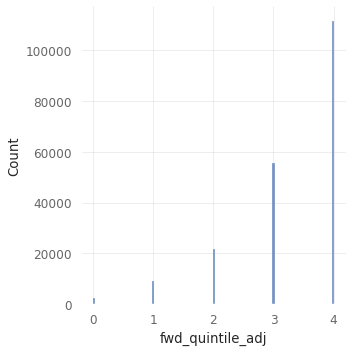

In [106]:
sns.displot(monthly_stock_data['fwd_quintile_adj'])

In [107]:

from sklearn.utils import class_weight

class_weights= class_weight.compute_class_weight('balanced', np.unique(monthly_stock_data['fwd_quintile_adj'].values), monthly_stock_data['fwd_quintile_adj'])
class_weights_dict  ={0:class_weights[0],1:class_weights[1],2:class_weights[2],3:class_weights[3],4:class_weights[4]}
class_weights_dict

Pass classes=[0 1 2 3 4], y=date
1986-04    3
1986-05    3
1986-06    2
1986-07    2
1986-08    2
          ..
2020-06    4
2020-07    4
2020-08    4
2020-09    4
2020-10    4
Name: fwd_quintile_adj, Length: 200393, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error


{0: 17.68693733451015,
 1: 4.343151278716949,
 2: 1.85781300699949,
 3: 0.7196215032139908,
 4: 0.359024294109216}

# Prediction Config 

In [108]:
final_stock_data_prop = pivot_table_stocks_total.copy(deep=True).sort_values(by='date', ascending=False)
final_factor_data_prop = monthly_factors_adj.copy(deep=True).sort_values(by='date', ascending=False)
final_macro_data_prop = macro_factors.copy(deep=True).sort_values(by='date', ascending=False)
test_data_factors_prop =  monthly_factors_adj.loc[(monthly_factors_adj.index>=('1977-01'))&(monthly_factors_adj.index<('2008-11'))].sort_values(by='date', ascending=False)
test_data_macro_prop = macro_factors.loc[(macro_factors.index>=('1977-01'))&(macro_factors.index<('2008-11'))].sort_values(by='date', ascending=False)


final_stock_data = monthly_stock_data.copy(deep=True)
final_factor_data = monthly_factors_adj.copy(deep=True)
final_macro_data = macro_factors.copy(deep=True)

window =  252*3
min_len = 200
batch_size = 8
n_factors = len(final_factor_data.columns)
patience_value = 25

start_date = ('1977-01')
end_date = ('2020-10')
Y_name = 'fwd_quintile_adj'


label_names = np.sort(final_stock_data[Y_name].unique())
label_names

array([0, 1, 2, 3, 4])

In [109]:
def fit_sample_weights(df,Y_name, weights_dict):
    df_copy = df.copy()
    df_copy['sample_weights'] = 0 
    
    for i in range(len(df_copy)):
        if df_copy[Y_name].iloc[i] ==0:
            df_copy['sample_weights'].iloc[i] = weights_dict[0]
            
        if df_copy[Y_name].iloc[i] ==1:
            df_copy['sample_weights'].iloc[i] = weights_dict[1]

        if df_copy[Y_name].iloc[i] ==2:
            df_copy['sample_weights'].iloc[i] = weights_dict[2]
            
        if df_copy[Y_name].iloc[i] ==3:
            df_copy['sample_weights'].iloc[i] = weights_dict[3]

        if df_copy[Y_name].iloc[i] ==4:
            df_copy['sample_weights'].iloc[i] = weights_dict[4]

    return df_copy.iloc[:,-1]

sample_weights = fit_sample_weights(monthly_stock_data , Y_name, class_weights_dict)



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [110]:
sample_weights = pd.concat([monthly_stock_data.permno, sample_weights],axis=1)
sample_weights

,permno,sample_weights
date,,
1986-04,10104.0,0.719622
1986-05,10104.0,0.719622
1986-06,10104.0,1.857813
1986-07,10104.0,1.857813
1986-08,10104.0,1.857813
...,...,...
2020-06,92655.0,0.359024
2020-07,92655.0,0.359024
2020-08,92655.0,0.359024


In [111]:
sample_weight_pivot = pd.pivot_table(data= sample_weights, index='date', columns='permno', values='sample_weights')
sample_weight_pivot.dropna(inplace=True)
sample_weight_array = sample_weight_pivot.values
sample_weight_array 

array([[0.7196215 , 0.7196215 , 0.35902429, ..., 0.35902429, 0.7196215 ,
        0.7196215 ],
       [0.7196215 , 0.7196215 , 0.35902429, ..., 0.35902429, 0.7196215 ,
        0.35902429],
       [0.7196215 , 0.7196215 , 0.35902429, ..., 0.35902429, 0.7196215 ,
        0.7196215 ],
       ...,
       [0.7196215 , 0.35902429, 0.35902429, ..., 0.35902429, 0.35902429,
        0.35902429],
       [0.7196215 , 0.35902429, 0.35902429, ..., 0.35902429, 0.35902429,
        0.35902429],
       [0.7196215 , 0.35902429, 0.35902429, ..., 0.35902429, 0.35902429,
        0.35902429]])

### local savings version

In [112]:
XGB_factors_only_file =   'XGB_factors_only_file.json'
XGB_merged_file =  'XGB_merged_file.json'

XGB_factors_prop =   'XGB_factors_prop.json'
XGB_merged_prop =  'XGB_merged_prop.json'


number_of_factors = final_factor_data.shape[1]
number_of_macro_factors = final_macro_data.shape[1] 
number_of_merged_factors = number_of_factors+number_of_macro_factors 

print('The dataset has: ', \
     number_of_factors, 'Smart-beta factors, ', \
     number_of_macro_factors, 'Macro factors, ', 'and',
     number_of_merged_factors, 'Total factors, ')

The dataset has:  33 Smart-beta factors,  136 Macro factors,  and 169 Total factors, 


# Gradient Boosted decision Trees

## Data Generation 

In [26]:
def xgb_data_generator_prop(stock_data_prop ,macro_data_prop, factor_data_prop,  train_set_ratio, val_set_ratio, test_data_factors, test_data_macro):
    """
    model = NN model, 
    data = stock data, factor data, macro data,
    batch_size = timesteps per batch
    alpha adam = learning rate optimizer
    data set ratios = train_set_ratio, val_set_ratio (eg. 0.5)
    """
    
    #complete data 
  
    stock_data_length = len(stock_data_prop)
    train_data_stocks = stock_data_prop.iloc[0:int(stock_data_length*train_set_ratio)]
    val_data_stocks = stock_data_prop.iloc[int(stock_data_length*train_set_ratio):int(stock_data_length*(val_set_ratio+train_set_ratio))]

        
    train_date_index = train_data_stocks.index.values.tolist() 
    val_date_index = val_data_stocks.index.values.tolist()

    #train data
    train_data_factors = factor_data_prop.loc[factor_data_prop.index.isin(train_date_index)]
    train_data_macro = macro_data_prop.loc[macro_data_prop.index.isin(train_date_index)]
    train_data_macro_norm = train_data_macro.copy(deep=True)

    for c in train_data_macro_norm.columns: 
        train_data_macro_norm[c] = MinMaxScaler([-1,1]).fit_transform(pd.DataFrame(train_data_macro_norm[c]))

    train_data_merged = pd.concat([train_data_factors, train_data_macro_norm],axis=1)

    #val data 
    val_data_factors = factor_data_prop.loc[factor_data_prop.index.isin(val_date_index)]
    val_data_macro = macro_data_prop.loc[macro_data_prop.index.isin(val_date_index)]    
    val_data_macro_norm = val_data_macro.copy(deep=True)

    for c in val_data_macro_norm.columns: 
        val_data_macro_norm[c] = MinMaxScaler([-1,1]).fit_transform(pd.DataFrame(val_data_macro_norm[c]))

    val_data_merged = pd.concat([val_data_factors, val_data_macro_norm],axis=1)

    #test data 
    test_data_macro_norm = test_data_macro.copy(deep=True)
    
    for c in test_data_macro_norm.columns: 
        test_data_macro_norm[c] = MinMaxScaler([-1,1]).fit_transform(pd.DataFrame(test_data_macro_norm[c]))

    test_data_merged = pd.concat([test_data_factors, test_data_macro_norm],axis=1)
    
    return train_data_stocks, train_data_factors,  train_data_merged, val_data_stocks, val_data_factors,  val_data_merged,   test_data_merged

In [30]:
 train_data_stocks, train_data_factors,  train_data_merged, val_data_stocks, val_data_factors,  val_data_merged,  test_data_merged = xgb_data_generator_prop(final_stock_data_prop ,final_macro_data_prop, final_factor_data_prop,  0.7, 0.1, test_data_factors_prop, test_data_macro_prop)

# Prediction function

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.model_selection import cross_val_score


def fit_xgb_complete(model_type,XGB_model_path, trainset, valset, y_train, y_val, test_data):
    """
    """
    xgb_model = xgb.XGBRegressor(max_depth=3, learning_rate=0.01, booster = 'gbtree', n_estimators=10000, verbosity=1, objective='reg:squarederror', num_classes=5)
    
    
    if model_type =='factors':
        # #training of factors only model
        fitted_model= xgb_model.fit(X=trainset, y=y_train   ,#sample_weight=sample_weights_list,
                                    eval_set=[(trainset, y_train),(valset, y_val)], early_stopping_rounds=500) 
        
        predictions = fitted_model.predict(test_data)
        feature_importances = fitted_model.get_booster().get_score(importance_type='weight')
        fitted_model.save_model(XGB_model_path)

    elif model_type =='merged':
        # #training of merged data model
        fitted_model= xgb_model.fit(X=trainset, y=y_train   ,#sample_weight=sample_weights_list,
                                    eval_set=[(trainset, y_train),(valset, y_val)], early_stopping_rounds=500) 
        predictions = fitted_model.predict(test_data)
        fitted_model.save_model(XGB_model_path)
        feature_importances = fitted_model.get_booster().get_score(importance_type='weight')
    return fitted_model, feature_importances, predictions

In [32]:
train_data_factors.shape
train_data_stocks.shape

(75, 501)

# Predicting the quintiles for stocks that weren't existent 

In [77]:
XGB_factors_prop =   'XGB_factors_prop.json'
XGB_merged_prop =  'XGB_merged_prop.json'

fitted_model_factors, feature_importances_prop_factors, prop_predictions_factors = fit_xgb_complete('factors',XGB_factors_prop, train_data_factors, val_data_factors, train_data_stocks, val_data_stocks, test_data_factors_prop)
fitted_model_merged, feature_importances_prop_merged, prop_predictions_merged= fit_xgb_complete('merged',XGB_merged_prop, train_data_merged, val_data_merged, train_data_stocks, val_data_stocks, test_data_merged)

[150]	validation_0-rmse:0.70897	validation_1-rmse:0.93900
[151]	validation_0-rmse:0.70260	validation_1-rmse:0.93507
[152]	validation_0-rmse:0.69629	validation_1-rmse:0.93121
[153]	validation_0-rmse:0.69002	validation_1-rmse:0.92737
[154]	validation_0-rmse:0.68383	validation_1-rmse:0.92366
[155]	validation_0-rmse:0.67770	validation_1-rmse:0.91994
[156]	validation_0-rmse:0.67163	validation_1-rmse:0.91633
[157]	validation_0-rmse:0.66562	validation_1-rmse:0.91275
[158]	validation_0-rmse:0.65967	validation_1-rmse:0.90928
[159]	validation_0-rmse:0.65377	validation_1-rmse:0.90581
[160]	validation_0-rmse:0.64794	validation_1-rmse:0.90242
[161]	validation_0-rmse:0.64216	validation_1-rmse:0.89909
[162]	validation_0-rmse:0.63644	validation_1-rmse:0.89584
[163]	validation_0-rmse:0.63077	validation_1-rmse:0.89266
[164]	validation_0-rmse:0.62517	validation_1-rmse:0.88950
[165]	validation_0-rmse:0.61961	validation_1-rmse:0.88639
[166]	validation_0-rmse:0.61412	validation_1-rmse:0.88334
[167]	validati

## saving feature improtances

In [87]:
feature_importances_prop_factors_df = feature_importances_prop_factors.copy()
feature_importances_prop_factors_df= pd.DataFrame.from_dict(feature_importances_prop_factors_df, orient='index')

feature_importances_prop_merged_df = feature_importances_prop_merged.copy()
feature_importances_prop_merged_df= pd.DataFrame.from_dict(feature_importances_prop_merged_df, orient='index')

# feature_importances_prop_merged_df.to_csv('feature_importances_prop_merged_df.csv')
# file_saver('feature_importances_prop_merged_df.csv', 'feature_importances_prop_merged_df.csv')

# feature_importances_prop_factors_df.to_csv('feature_importances_prop_factors_df.csv')
# file_saver('feature_importances_prop_factors_df.csv', 'feature_importances_prop_factors_df.csv')

## Merging dataframe with missing values with predicted quintiles

In [95]:
prop_predictions_merged = pd.DataFrame(prop_predictions_merged)
prop_predictions_factors = pd.DataFrame(prop_predictions_factors)

In [103]:
uncomplete_df = pivot_table_stocks.copy()
uncomplete_df = uncomplete_df.loc[(uncomplete_df.index>=('1977-01'))&(uncomplete_df.index<=('2008-10'))]
uncomplete_df = uncomplete_df.sort_values(by='date', ascending=False)
uncomplete_df


prop_predictions_factors.index = test_data_factors_prop.index[:]
prop_predictions_factors.columns = pivot_table_stocks.columns
prop_predictions_factors = prop_predictions_factors.round().sort_values(by='date',ascending=False)
prop_predictions_factors


prop_predictions_merged.index = test_data_factors_prop.index[:]
prop_predictions_merged.columns = pivot_table_stocks.columns
prop_predictions_merged = prop_predictions_merged.round().sort_values(by='date',ascending=False)
prop_predictions_merged

def value_propagation(df, df_prop):
    altered_df = df.copy()
    for i in df.columns:
        if any(df[i].isna()): 
            
            isna_index = df.loc[pd.isna(df[i]), :].index.values
            altered_df.loc[isna_index,i] = df_prop.loc[isna_index, i].values

    return altered_df

complete_stock_quintiles_factors = value_propagation(uncomplete_df, prop_predictions_factors)
complete_stock_quintiles_factors = complete_stock_quintiles_factors.sort_values(by='date')
complete_stock_quintiles_factors

complete_stock_quintiles_merged = value_propagation(uncomplete_df, prop_predictions_merged)
complete_stock_quintiles_merged = complete_stock_quintiles_merged.sort_values(by='date')
complete_stock_quintiles_merged

permno,10104.0,10107.0,10138.0,10145.0,10516.0,10696.0,10909.0,11308.0,11403.0,11404.0,...,92121.0,92157.0,92239.0,92293.0,92322.0,92402.0,92602.0,92611.0,92614.0,92655.0
date,,,,,,,,,,,,,,,,,,,,,
1977-07,3.0,3.0,4.0,4.0,3.0,4.0,3.0,4.0,2.0,3.0,...,3.0,3.0,3.0,2.0,4.0,3.0,4.0,4.0,3.0,4.0
1977-08,3.0,3.0,4.0,4.0,3.0,4.0,3.0,4.0,2.0,3.0,...,3.0,3.0,3.0,2.0,4.0,3.0,4.0,4.0,3.0,4.0
1977-09,3.0,3.0,4.0,4.0,3.0,4.0,3.0,4.0,2.0,3.0,...,3.0,3.0,3.0,2.0,4.0,3.0,4.0,4.0,3.0,4.0
1977-10,3.0,3.0,4.0,4.0,3.0,4.0,3.0,4.0,2.0,3.0,...,3.0,3.0,3.0,2.0,4.0,3.0,4.0,4.0,3.0,4.0
1977-11,3.0,3.0,4.0,4.0,3.0,4.0,3.0,4.0,2.0,3.0,...,3.0,3.0,3.0,2.0,4.0,3.0,4.0,4.0,3.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-06,3.0,3.0,4.0,4.0,3.0,4.0,4.0,4.0,1.0,3.0,...,2.0,3.0,3.0,3.0,1.0,3.0,4.0,4.0,2.0,3.0
2008-07,3.0,3.0,4.0,4.0,3.0,4.0,4.0,4.0,1.0,4.0,...,2.0,3.0,3.0,3.0,1.0,3.0,4.0,4.0,3.0,3.0
2008-08,3.0,3.0,4.0,4.0,3.0,4.0,4.0,4.0,1.0,4.0,...,2.0,3.0,3.0,2.0,2.0,3.0,4.0,4.0,3.0,3.0


In [100]:
to_merge = pivot_table_stocks.loc[pivot_table_stocks.index>('2008-10')]
complete_stock_quintiles = pd.concat([complete_stock_quintiles_merged, to_merge],axis=0)
complete_stock_quintiles = complete_stock_quintiles.apply(lambda x: x.fillna(x.mean(),axis=0))
complete_stock_quintiles = complete_stock_quintiles.dropna()
complete_stock_quintiles

(375, 501)

In [ ]:
# complete_stock_quintiles_factors.to_csv('complete_stock_quintiles_factors.csv')
# file_saver('complete_stock_quintiles_factors.csv', 'complete_stock_quintiles_factors.csv')

# complete_stock_quintiles_merged.to_csv('complete_stock_quintiles_merged.csv')
# file_saver('complete_stock_quintiles_merged.csv', 'complete_stock_quintiles_merged.csv')

# complete_stock_quintiles.to_csv('complete_stock_quintiles.csv')
# file_saver('complete_stock_quintiles.csv', 'complete_stock_quintiles.csv')

In [33]:
path_bucket

's3://mm-master-thesis-data/'

In [113]:
complete_stock_quintiles = pd.read_csv(path_bucket+'complete_stock_quintiles.csv')
complete_stock_quintiles = complete_stock_quintiles.sort_values(by='date')
complete_stock_quintiles.columns.name = 'permno'
complete_stock_quintiles.set_index('date',inplace=True)
complete_stock_quintiles

permno,10104.0,10107.0,10138.0,10145.0,10516.0,10696.0,10909.0,11308.0,11403.0,11404.0,...,92121.0,92157.0,92239.0,92293.0,92322.0,92402.0,92602.0,92611.0,92614.0,92655.0
date,,,,,,,,,,,,,,,,,,,,,
1977-07,3.0,3.0,4.0,4.0,3.0,4.0,3.0,4.0,2.0,3.0,...,3.0,3.0,3.0,2.0,4.0,3.0,4.0,4.0,3.0,4.0
1977-08,3.0,3.0,4.0,4.0,3.0,4.0,3.0,4.0,2.0,3.0,...,3.0,3.0,3.0,2.0,4.0,3.0,4.0,4.0,3.0,4.0
1977-09,3.0,3.0,4.0,4.0,3.0,4.0,3.0,4.0,2.0,3.0,...,3.0,3.0,3.0,2.0,4.0,3.0,4.0,4.0,3.0,4.0
1977-10,3.0,3.0,4.0,4.0,3.0,4.0,3.0,4.0,2.0,3.0,...,3.0,3.0,3.0,2.0,4.0,3.0,4.0,4.0,3.0,4.0
1977-11,3.0,3.0,4.0,4.0,3.0,4.0,3.0,4.0,2.0,3.0,...,3.0,3.0,3.0,2.0,4.0,3.0,4.0,4.0,3.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06,3.0,4.0,4.0,4.0,3.0,4.0,4.0,3.0,4.0,4.0,...,3.0,4.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0
2020-07,3.0,4.0,4.0,4.0,3.0,4.0,4.0,3.0,4.0,4.0,...,3.0,4.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0
2020-08,3.0,4.0,4.0,4.0,3.0,4.0,4.0,3.0,4.0,4.0,...,3.0,4.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0


In [116]:
complete_stock_quintiles.values.min()

0.0

## Creating the complete data for the final regression

In [117]:
def xgb_data_generator(model_type, stock_data,macro_data, factor_data, train_set_ratio, val_set_ratio, Y_name):
    """
    model = NN model, 
    data = stock data, factor data, macro data,
    batch_size = timesteps per batch
    alpha adam = learning rate optimizer
    data set ratios = train_set_ratio, val_set_ratio (eg. 0.5)
    """
    
    #complete data 
    trainset = pd.DataFrame()
    valset = pd.DataFrame()
    testset = pd.DataFrame()
    test_data_df = pd.DataFrame()
    
    
    stock_data_length = len(stock_data)
    train_data_stocks = stock_data.iloc[0:int(stock_data_length*train_set_ratio)]
    val_data_stocks = stock_data.iloc[int(stock_data_length*train_set_ratio):int(stock_data_length*(val_set_ratio+train_set_ratio))]
    test_data_stocks = stock_data.iloc[int(stock_data_length*(val_set_ratio+train_set_ratio)):]
        
    train_date_index = train_data_stocks.index.values.tolist() 
    val_date_index = val_data_stocks.index.values.tolist()
    test_date_index = test_data_stocks.index.values.tolist()

    #train data
    train_data_factors = factor_data.loc[factor_data.index.isin(train_date_index)]
    train_data_macro = macro_factors.loc[macro_factors.index.isin(train_date_index)]
    train_data_macro_norm = train_data_macro.copy(deep=True)

    for c in train_data_macro_norm.columns: 
        train_data_macro_norm[c] = MinMaxScaler([-1,1]).fit_transform(pd.DataFrame(train_data_macro_norm[c]))

    train_data_merged = pd.concat([train_data_factors, train_data_macro_norm],axis=1)

    #val data 
    val_data_factors = factor_data.loc[factor_data.index.isin(val_date_index)]
    val_data_macro = macro_factors.loc[macro_factors.index.isin(val_date_index)]    
    val_data_macro_norm = val_data_macro.copy(deep=True)

    for c in val_data_macro_norm.columns: 
        val_data_macro_norm[c] = MinMaxScaler([-1,1]).fit_transform(pd.DataFrame(val_data_macro_norm[c]))

    val_data_merged = pd.concat([val_data_factors, val_data_macro_norm],axis=1)

    #test data 
    test_data_factors = factor_data.loc[factor_data.index.isin(test_date_index)]
    test_data_macro = macro_data.loc[macro_data.index.isin(test_date_index)] 
    test_data_macro_norm = test_data_macro.copy(deep=True)

    for c in test_data_macro_norm.columns: 
        test_data_macro_norm[c] = MinMaxScaler([-1,1]).fit_transform(pd.DataFrame(test_data_macro_norm[c]))

    test_data_merged = pd.concat([test_data_factors, test_data_macro_norm],axis=1)
    
    return train_data_stocks, train_data_factors,  train_data_merged, val_data_stocks, val_data_factors,  val_data_merged, test_data_stocks, test_data_factors,  test_data_merged

In [118]:
"""xgb_data_generator(model_type, stock_data,macro_data, factor_data, batch_size, train_set_ratio, val_set_ratio, Y_name):"""

y_train, train_data_factors,  train_data_merged, y_val, val_data_factors,  val_data_merged, y_test, test_data_factors,  test_data_merged= xgb_data_generator('factors', complete_stock_quintiles,final_macro_data, final_factor_data, 0.7, 0.1, Y_name)


In [119]:
XGB_factors_only_file =   'XGB_factors_only_file.json'
XGB_merged_file = 'XGB_merged_file.json'

In [ ]:
# best score factors only   rmse 0.30451     best score merged with macro data  :rmse  0.064

# Final XGB predictions

In [53]:
fitted_model_factors_final, feature_importances_factors, predictions_factors = fit_xgb_complete('factors',XGB_factors_only_file, train_data_factors, val_data_factors, y_train, y_val, test_data_factors)
fitted_model_merged_final, feature_importances_merged, predictions_merged= fit_xgb_complete('merged',XGB_merged_file, train_data_merged, val_data_merged, y_train, y_val, test_data_merged)

[00:40:49] WARNING: ../src/learner.cc:627: 
Parameters: { "num_classes" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:2.96118	validation_1-rmse:2.87299
[1]	validation_0-rmse:2.93305	validation_1-rmse:2.84590
[2]	validation_0-rmse:2.90520	validation_1-rmse:2.81910
[3]	validation_0-rmse:2.87765	validation_1-rmse:2.79259
[4]	validation_0-rmse:2.85039	validation_1-rmse:2.76640
[5]	validation_0-rmse:2.82341	validation_1-rmse:2.74048
[6]	validation_0-rmse:2.79670	validation_1-rmse:2.71485
[7]	validation_0-rmse:2.77028	validation_1-rmse:2.68951
[8]	validation_0-rmse:2.74413	validation_1-rmse:2.66448
[9]	validation_0-rmse:2.71825	validation_1-rmse:2.63969
[10]	validation_0-rmse:2.69264	validation_1-rmse:2.61521
[11]	validation_0-rms

In [ ]:
# factor model rmse 0.30451    rmse 0.91965
# merged mdoel rmse 0.06422    rmse 1.00053

In [ ]:
def quintile_adapter(df): 
    df_copy= df.copy(deep=True)
    max_value = df_copy.values.max()
    min_value = df_copy.values.min()
    max_list = np.arange(1,max_value+1)
    min_list = list(np.arange(min_value, 1, dtype=int))
    
    for i in range(5, len(max_list)):
        df_copy = df_copy.replace(max_list[i], 5)
    
    if len(min_list)>=1:
        for i in range(min_list[0], 1):
            print(i)
            df_copy= df_copy.replace(min_list[i], 1)
        
    return df_copy


In [55]:
feature_importances_factors_df = feature_importances_factors.copy()
feature_importances_factors_df= pd.DataFrame.from_dict(feature_importances_factors_df, orient='index')

feature_importances_merged_df = feature_importances_merged.copy()
feature_importances_merged_df= pd.DataFrame.from_dict(feature_importances_merged_df, orient='index')

feature_importances_factors_df.to_csv('feature_importances_factors_df.csv')
file_saver('feature_importances_factors_df.csv', 'feature_importances_factors_df.csv')

feature_importances_merged_df.to_csv('feature_importances_merged_df.csv')
file_saver('feature_importances_merged_df.csv', 'feature_importances_merged_df.csv')

predictions_merged = pd.DataFrame(predictions_merged)
predictions_factors = pd.DataFrame(predictions_factors)

predictions_merged = predictions_merged.to_csv('xgb_predictions_merged.csv')
file_saver('xgb_predictions_merged.csv', 'xgb_predictions_merged.csv')

predictions_factors = predictions_factors.to_csv('xgb_predictions_factors.csv')
file_saver('xgb_predictions_factors.csv','xgb_predictions_factors.csv')

In [56]:
predictions_merged = pd.DataFrame(predictions_merged)
predictions_factors = pd.DataFrame(predictions_factors)

In [135]:
predictions_factors = pd.read_csv(path_bucket+'xgb_predictions_factors.csv', index_col=0)
predictions_factors.index = y_test.index
predictions_factors.columns = y_test.columns
predictions_factors.columns.name = 'permno'
predictions_factors = predictions_factors.round()

predictions_merged = pd.read_csv(path_bucket+'xgb_predictions_merged.csv', index_col=0)
predictions_merged.index = y_test.index
predictions_merged.columns = y_test.columns
predictions_merged.columns.name = 'permno'
predictions_merged = predictions_merged.round()

final_stock_data_pivot = pd.read_csv(path_bucket + 'complete_stock_quintiles.csv',index_col=0)

In [142]:
y_test

permno,10104.0,10107.0,10138.0,10145.0,10516.0,10696.0,10909.0,11308.0,11403.0,11404.0,...,92121.0,92157.0,92239.0,92293.0,92322.0,92402.0,92602.0,92611.0,92614.0,92655.0
date,,,,,,,,,,,,,,,,,,,,,
2012-02,3.0,3.0,4.0,4.0,3.0,4.0,4.0,4.0,1.0,4.0,...,3.0,3.0,4.0,4.0,4.0,3.0,4.0,4.0,3.0,4.0
2012-03,3.0,3.0,4.0,4.0,3.0,4.0,4.0,4.0,1.0,4.0,...,3.0,3.0,4.0,4.0,4.0,3.0,4.0,4.0,3.0,4.0
2012-04,3.0,3.0,4.0,4.0,3.0,4.0,4.0,4.0,1.0,4.0,...,3.0,3.0,4.0,4.0,4.0,3.0,4.0,4.0,3.0,4.0
2012-05,3.0,3.0,4.0,4.0,3.0,4.0,4.0,4.0,1.0,4.0,...,3.0,3.0,4.0,4.0,4.0,3.0,4.0,4.0,3.0,4.0
2012-06,3.0,3.0,4.0,4.0,3.0,4.0,4.0,4.0,1.0,4.0,...,3.0,3.0,4.0,4.0,4.0,3.0,4.0,4.0,3.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06,3.0,4.0,4.0,4.0,3.0,4.0,4.0,3.0,4.0,4.0,...,3.0,4.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0
2020-07,3.0,4.0,4.0,4.0,3.0,4.0,4.0,3.0,4.0,4.0,...,3.0,4.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0
2020-08,3.0,4.0,4.0,4.0,3.0,4.0,4.0,3.0,4.0,4.0,...,3.0,4.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0


In [137]:
predictions_merged

permno,10104.0,10107.0,10138.0,10145.0,10516.0,10696.0,10909.0,11308.0,11403.0,11404.0,...,92121.0,92157.0,92239.0,92293.0,92322.0,92402.0,92602.0,92611.0,92614.0,92655.0
date,,,,,,,,,,,,,,,,,,,,,
2012-02,3.0,4.0,3.0,4.0,3.0,3.0,3.0,4.0,2.0,3.0,...,3.0,3.0,4.0,2.0,4.0,3.0,4.0,4.0,3.0,4.0
2012-03,3.0,4.0,4.0,4.0,3.0,3.0,3.0,4.0,3.0,2.0,...,3.0,3.0,4.0,2.0,4.0,3.0,4.0,4.0,3.0,4.0
2012-04,3.0,4.0,3.0,4.0,3.0,3.0,3.0,4.0,3.0,2.0,...,3.0,4.0,4.0,2.0,4.0,3.0,4.0,4.0,3.0,4.0
2012-05,3.0,4.0,4.0,4.0,3.0,3.0,3.0,4.0,3.0,3.0,...,3.0,4.0,4.0,2.0,4.0,3.0,4.0,4.0,3.0,4.0
2012-06,3.0,4.0,4.0,4.0,3.0,3.0,3.0,4.0,3.0,2.0,...,3.0,4.0,4.0,2.0,4.0,3.0,4.0,4.0,3.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06,2.0,3.0,4.0,3.0,2.0,3.0,4.0,4.0,2.0,4.0,...,3.0,3.0,2.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0
2020-07,2.0,3.0,4.0,3.0,2.0,3.0,4.0,4.0,2.0,4.0,...,3.0,3.0,2.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0
2020-08,2.0,3.0,4.0,3.0,2.0,3.0,4.0,4.0,2.0,4.0,...,3.0,3.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0


In [150]:
def r2_oos(true_values, pred_values):
    r2 = 1 - ((sum((true_values-pred_values)**2))/(sum(true_values**2)))
    return r2 


def create_metrics(test_data_df, prediction_df, n_factors, r2_oos,dataframe_name):
    prediction_df = prediction_df.copy()
    prediction_df = prediction_df.reset_index().melt(id_vars=['date'])
    prediction_df = prediction_df.round()
    prediction_df.value = prediction_df.value+1
    
    test_data_df = test_data_df.copy()
    test_data_df = test_data_df.reset_index().melt(id_vars=['date'])
    test_data_df.value = test_data_df.value+1
    
    comparison = pd.merge(test_data_df, prediction_df, how='left', on=['date', 'permno'])
    comparison = comparison.rename(columns={'value_x':'true quint', 'value_y':'pred quint'})
    r2= r2_score(comparison.iloc[:,2],comparison.iloc[:,3])
    r2_oos = r2_oos(comparison.iloc[:,2],comparison.iloc[:,3])
    
    r2_adj = 1-(1-r2)*(len(comparison.iloc[:,3])-1)/((len(comparison.iloc[:,3])-n_factors-1))
    r2_adj_oos = 1-(1-r2_oos)*(len(comparison.iloc[:,3])-1)/((len(comparison.iloc[:,3])-n_factors-1))
    MSE = mean_squared_error(comparison.iloc[:,2],comparison.iloc[:,3])
    rss = np.sum((comparison.iloc[:,3]-comparison.iloc[:,2])**2)

    df_metrics =  pd.DataFrame(data=[r2,r2_oos,r2_adj,r2_adj_oos, MSE, rss])
    df_metrics=df_metrics.rename(index={0:'r2',1:'r2_oos', 2:'r2_adj', 3:'r2_adj_oos',4:'MSE',5:'rss'},columns={0:dataframe_name})
    return comparison, df_metrics

In [151]:
xgb_predictions_factors_results, xgb_predictions_factors_metrics = create_metrics(y_test, predictions_factors, n_factors, r2_oos, 'XGB_factors_metrics')
xgb_predictions_merged_results, xgb_predictions_merged_metrics= create_metrics(y_test, predictions_merged, n_factors, r2_oos, 'XGB_merged_metrics')


In [152]:
xgb_predictions_factors_results.to_csv('xgb_predictions_factors_results.csv')
file_saver('xgb_predictions/xgb_predictions_factors_results.csv', 'xgb_predictions_factors_results.csv')

xgb_predictions_factors_metrics.to_csv('xgb_predictions_factors_metrics.csv')
file_saver('xgb_predictions/xgb_predictions_factors_metrics.csv', 'xgb_predictions_factors_metrics.csv')

xgb_predictions_merged_results.to_csv('xgb_predictions_merged_results.csv')
file_saver('xgb_predictions/xgb_predictions_merged_results.csv', 'xgb_predictions_merged_results.csv')

xgb_predictions_merged_metrics.to_csv('xgb_predictions_merged_metrics.csv')
file_saver('xgb_predictions/xgb_predictions_merged_metrics.csv', 'xgb_predictions_merged_metrics.csv')

In [162]:
xgb_predictions_factors_results['true quint'].values.max()

5.0

In [39]:
import xgboost as xgb

xgb_model_factors = xgb.XGBRegressor()
xgb_model_factors.load_model('XGB_factors_only_file.json')
feature_importances_factors = xgb_model_factors.get_booster().get_score(importance_type='weight')


xgb_model_merged = xgb.XGBRegressor()
xgb_model_merged.load_model('XGB_merged_file.json')


In [40]:
feature_importances_factors = xgb_model_factors.get_booster().get_score(importance_type='weight')
feature_importances_factors_fscore = xgb_model_factors.get_booster().get_fscore()

feature_importances_merged = xgb_model_merged.get_booster().get_score(importance_type='weight')
feature_importance_merged_fscore = xgb_model_merged.get_booster().get_fscore()

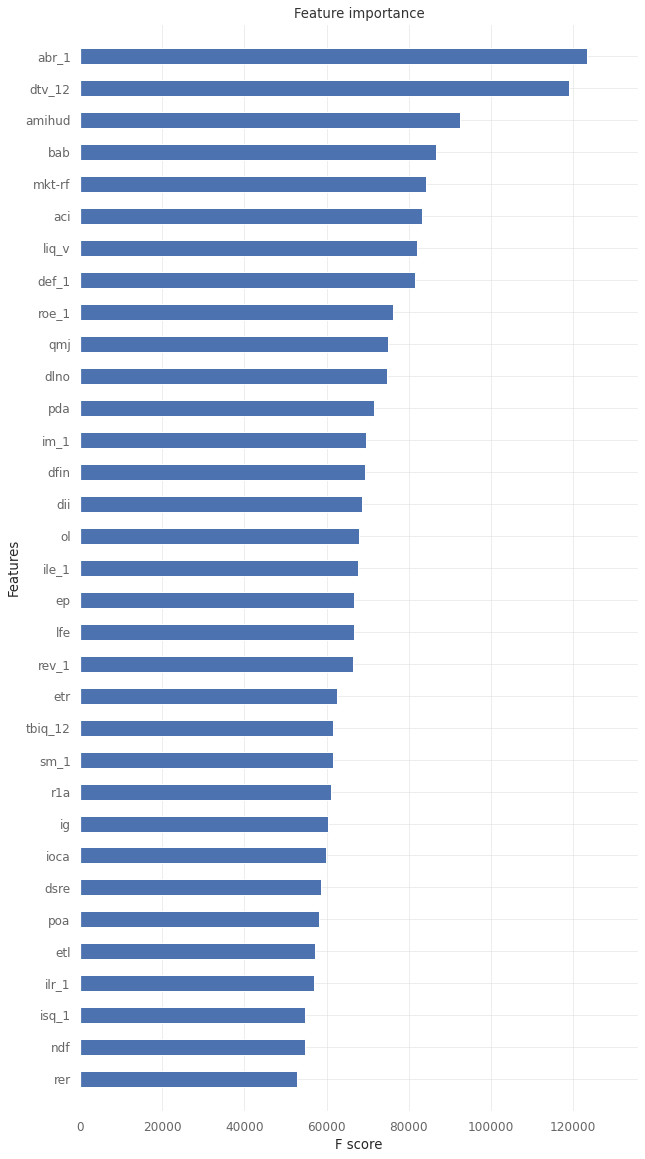

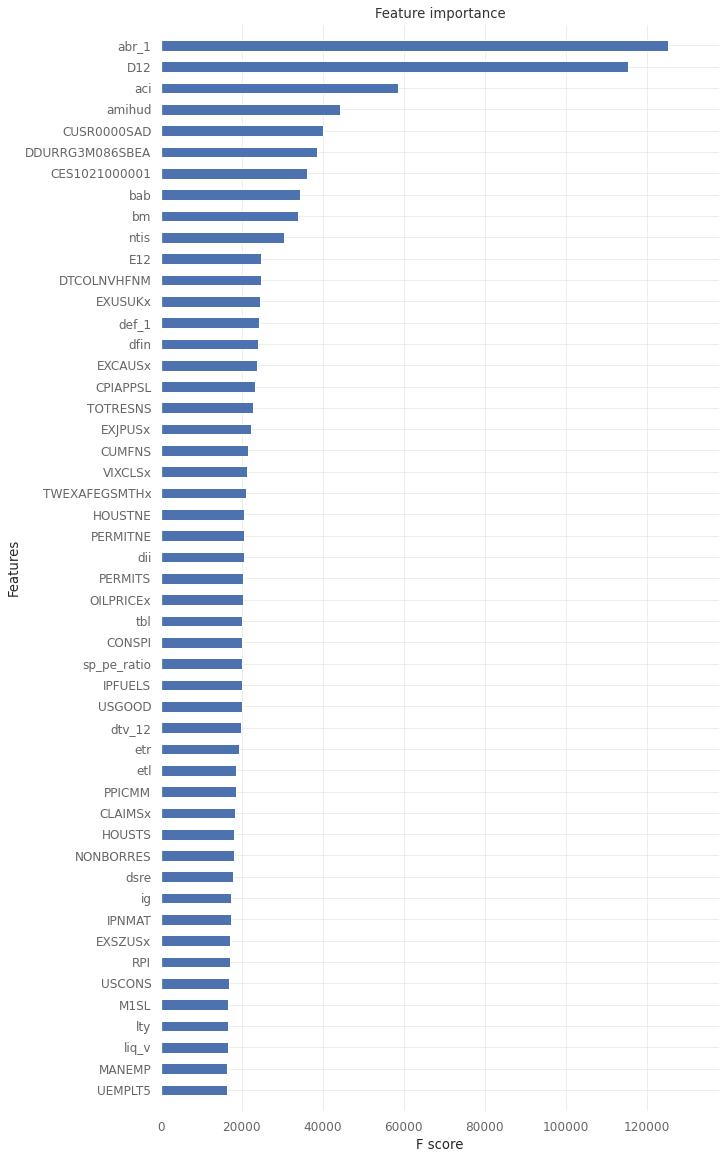

In [64]:
#plot feature importance
from xgboost import plot_importance
from matplotlib import pyplot

# fig, ax1, ax2 = plt.subplots(figsize=(10,20))
plt.rcParams["figure.figsize"] = (10,20)
feature_importance_factors_graph = plot_importance(xgb_model_factors,height=0.5,  show_values=False )
plt.savefig('feature_importance_factors_graph.jpg')

feature_importance_merged_graph = plot_importance(xgb_model_merged,height=0.5, show_values=False, max_num_features=50)

plt.savefig('feature_importance_merged_graph.jpg')


In [ ]:

#plot tree
xgb.plot_tree(xgb_model_factors)
xgb.plot_tree(xgb_model_merged)

In [ ]:
plt.bar()

## Visualisation

## Neural Networks

In [ ]:
checkpoints_LSTM_model_merged_1L = 'checkpoints_LSTM_model_merged_1L'
checkpoints_LSTM_model_merged_2L = 'checkpoints_LSTM_model_merged_2L'
checkpoints_LSTM_model_merged_3L = 'checkpoints_LSTM_model_merged_3L'
checkpoints_LSTM_model_merged_4L = 'checkpoints_LSTM_model_merged_4L'

checkpoints_LSTM_model_1L = 'checkpoints_LSTM_model_1L'
checkpoints_LSTM_model_2L = 'checkpoints_LSTM_model_2L'
checkpoints_LSTM_model_3L = 'checkpoints_LSTM_model_3L'
checkpoints_LSTM_model_4L = 'checkpoints_LSTM_model_4L'

checkpoints_LSTM_model_macro_1L = 'checkpoints_LSTM_model_macro_1L'
checkpoints_LSTM_model_macro_2L = 'checkpoints_LSTM_model_macro_2L'
checkpoints_LSTM_model_macro_3L = 'checkpoints_LSTM_model_macro_3L'
checkpoints_LSTM_model_macro_4L = 'checkpoints_LSTM_model_macro_4L'

checkpoints_FFN_model_L1 = 'checkpoints_FFN_model_L1'
checkpoints_FFN_model_L2 = 'checkpoints_FFN_model_L2'
checkpoints_FFN_model_L3 = 'checkpoints_FFN_model_L3'
checkpoints_FFN_model_L4 = 'checkpoints_FFN_model_L4'

In [ ]:
model_LSTM_merged_1L = tf.keras.models.load_model(checkpoints_LSTM_model_merged_1L)
model_LSTM_merged_2L = tf.keras.models.load_model(checkpoints_LSTM_model_merged_2L)
model_LSTM_merged_3L = tf.keras.models.load_model(checkpoints_LSTM_model_merged_3L)
model_LSTM_merged_4L = tf.keras.models.load_model(checkpoints_LSTM_model_merged_4L)

model_LSTM_1L = tf.keras.models.load_model(checkpoints_LSTM_model_1L)
model_LSTM_2L = tf.keras.models.load_model(checkpoints_LSTM_model_2L)
model_LSTM_3L = tf.keras.models.load_model(checkpoints_LSTM_model_3L)
model_LSTM_4L = tf.keras.models.load_model(checkpoints_LSTM_model_4L)

model_FFN_1L = tf.keras.models.load_model(checkpoints_FFN_model_L1)
model_FFN_2L = tf.keras.models.load_model(checkpoints_FFN_model_L2)
model_FFN_3L = tf.keras.models.load_model(checkpoints_FFN_model_L3)
model_FFN_4L = tf.keras.models.load_model(checkpoints_FFN_model_L4)


xgb_model_factors = xgb.Booster()
xgb_model_factors = xgb_model_factors.load_model(XGB_factors_only_file)

xgb_model_merged = xgb.Booster()
xgb_model_merged = xgb_model_factors.load_model(XGB_factors_only_file)

In [76]:
import shap
# features_factors = final_factor_data.columns.tolist()
# features_macro = final_macro_data.columns.tolist()
# features_merged = features_factors +features_macro

# background_factors = x_train_factors[:500]
# background_macro = x_train_macro[:500]
# background_merged = x_train_merged[:500]

# test_factors = x_test_factors[:500] 
# test_macro = x_test_macro[:500]
# test_merged = x_test_merged[:500]

explainer = shap.TreeExplainer(xgb_model_factors, train_data_factors)
shap_values = explainer.shap_values(test_data_factors)
shap.summary_plot(shap_values, label_names=train_data_factors.columns)
shap.bar_plot(shap_values[0])

# explainer = shap.DeepExplainer(model_LSTM_merged_1L, background_merged)
# shap_values = explainer.shap_values(test_merged)
# shap.summary(shap_values)
# shap.bar_plot(shap_values)

# explainer = shap.DeepExplainer(model_LSTM_merged_1L, background_merged)
# shap_values = explainer.shap_values(test_merged)
# shap.summary(shap_values)
# shap.bar_plot(shap_values)

# explainer = shap.DeepExplainer(model_LSTM_merged_1L, background_merged)
# shap_values = explainer.shap_values(test_merged)
# shap.summary(shap_values)
# shap.bar_plot(shap_values)

KeyboardInterrupt: 